# Estimating MI by Probabilistic Classifier Method (PCM)

## Setup

The following cell imports the necessary packages:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import argparse
from torch.autograd import Variable
import itertools
from tqdm import tqdm
from data.mix_gaussian import MixedGaussian
from data.gaussian import Gaussian
from model.utils import *

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

Use GPU if GPU is available.

In [2]:
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)
Tensor = FloatTensor
#Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Set random seed for reproducibility.

In [3]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

Specify the hyper-parameters:

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=6, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=1e-8, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_iters", type=int, default=60000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=100, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
# parser.add_argument("--latent_dim", type=int, default=1, help="dimensionality of the latent space")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--c_0_1_ratio", type=float, default=1, help="Ratio of samples with label 0 and samples with label 1 ")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--alpha", type=float, default=1e-4, help="smooth parameter")


# opt = parser.parse_args()
opt, unknown = parser.parse_known_args()

Specify the distribution to generate the data samples:

In [5]:
# Two choices here: 'Gaussian' and 'MixedGaussian
density = 'Gaussian'

## Model

Define the function `generate_data` for generating Gaussian or Mixed Gaussian distributions.

- When generating Gaussian distrition, ${X}$ and ${Y}$ are distributed as 
\begin{align} 
p_{XY} = \prod_{i=1}^d \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}1 & \rho \\ \rho & 1\\ \end{bmatrix} \right) 
\end{align}
- When generating Mixed Gaussian distributions, ${X}$ and ${Y}$ are distributed as 
 \begin{align} 
 p_{XY} = \frac{1}{2} \prod_{i=1}^d \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}1 & \rho \\ \rho & 1\\ \end{bmatrix} \right) + \frac{1}{2} \prod_{i=1}^d \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}1 & {-} \rho \\ {-} \rho & 1\\ \end{bmatrix} \right) 
 \end{align}

In [6]:
def generate_data(distribution='Gaussian', rho=0.9):
    # rho is the covariance for generating distributions
    # mu1 and mu2 are means for generating Mixed Gaussian distribution 
    mu1 = 0
    mu2 = 0

    # mg is an object of Class Gaussian or MixedGaussian
    if distribution=='Gaussian':
        mg = Gaussian(sample_size=opt.sample_size,rho=rho)
    else:
        mg = MixedGaussian(sample_size=opt.sample_size, mean1=mu1, mean2=mu2,rho1=rho, rho2=-rho)

    # Calculate the ground truth MI between X and Y for (X, Y) from mg
    mi = mg.ground_truth * opt.d

    # Create X, Y for storing generated samples
    X = np.zeros((opt.sample_size,opt.d))
    Y = np.zeros((opt.sample_size,opt.d))

    # Generate samples of random variable X,Y and XY
    for j in range(opt.d):
        # In each iteration, mg.data will generate samples of two dimensions where one dimension for X and another for Y respectively 
        data = mg.data
        X[:,j] = data[:,0]
        Y[:,j] = data[:,1]        
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    XY = torch.cat((X, Y), dim=1)

    return XY, X, Y, mi

Define the neural network.


In [7]:
class Net(nn.Module):
    # Inner class that defines the neural network architecture
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = F.sigmoid(self.fc3(output))
        return output

The function `_resample` below is for resampling the given data samples for training the neural network.

In [8]:
def _resample(data, batch_size, replace=False):
    # Resample the given data sample.
    index = np.random.choice(
        range(data.shape[0]), size=batch_size, replace=replace)
    batch = data[index]
    return batch


The neural network `discriminator` below implements and outputs $p_{{C} | \tilde{X}\tilde{Y}}(1|x,y)$ before clipping:

In [9]:
discriminator = Net(input_size=opt.d*2, hidden_size=100)
# move NN model GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam opetimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))


## Training

The estimate of MI given by Probabilistic Classifier Method (PCM) is as follows:
\begin{align}
I(X, Y) = E \left[ \ln r(X, Y) \right],
\end{align}
where
\begin{align}
r(X, Y) := \frac{p_{C}(0)}{p_{C}(1)} \cdot \frac{p_{{C} | \tilde{X}\tilde{Y}} (1|x,y)}{p_{{C} | \tilde{X}\tilde{Y}} (0|x,y)}.
\end{align}

To obtain MI estimate of given samples by Probabilistic Classifier Method (PCM), we train the neural network $\hat{p}_{\theta}$ to implement $p_{{C} | \tilde{X}\tilde{Y}}(1|x,y)$ by minimizing the cross-entropy of $\hat{p}_{\theta}$ relative to $p_{{C} | \tilde{X}\tilde{Y}}$.

The output of the neural network $\hat{p}_{\theta}$ may be clipped to a certain range before used for calculating MI estimate.

The following cell train the neural network using the data samples.



In [10]:
XY, X, Y, Ground_truth = generate_data(distribution=density, rho=opt.rho)
mi_list = [] # storing the infoNCE of each iteration
for i in range(opt.n_iters):
    data_joint = _resample(XY, batch_size=opt.batch_size)
    X_ref = resample(X, batch_size=opt.batch_size)
    Y_ref = resample(Y, batch_size=opt.batch_size)
    data_margin = torch.cat((X_ref, Y_ref), dim=1)
    valid = Variable(Tensor(opt.batch_size, 1).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(opt.batch_size, 1).fill_(0.0), requires_grad=False)
    train_data = torch.cat((data_joint, data_margin), dim=0)
    labels = torch.cat((valid, fake), dim=0)
    pred_label = discriminator(train_data)
    alpha = data_margin.shape[0]/data_joint.shape[0]


    optimizer_D.zero_grad()
    # PCM loss
    loss = torch.nn.BCELoss()(pred_label, labels)

    loss.backward()
    optimizer_D.step()
    with torch.no_grad():
        mi_est = mi_estimate(discriminator, XY, opt.gamma, alpha)
        if torch.isinf(mi_est):
            mi_est = torch.from_numpy(np.array(mi_list[-1]))

        mi_list.append(mi_est.item())
    if i%500==0:
        print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))

Iternation: 0, loss: 0.693223, mi_est: -0.000029
Iternation: 500, loss: 0.693634, mi_est: 0.000401
Iternation: 1000, loss: 0.660788, mi_est: 0.078258
Iternation: 1500, loss: 0.417887, mi_est: 0.765704
Iternation: 2000, loss: 0.261239, mi_est: 1.550122
Iternation: 2500, loss: 0.160774, mi_est: 2.225321
Iternation: 3000, loss: 0.154793, mi_est: 2.508961
Iternation: 3500, loss: 0.113935, mi_est: 2.835624
Iternation: 4000, loss: 0.069262, mi_est: 3.347457
Iternation: 4500, loss: 0.096260, mi_est: 3.467861
Iternation: 5000, loss: 0.095573, mi_est: 3.916479
Iternation: 5500, loss: 0.075275, mi_est: 3.778171
Iternation: 6000, loss: 0.092295, mi_est: 4.018588
Iternation: 6500, loss: 0.062088, mi_est: 4.154118
Iternation: 7000, loss: 0.073415, mi_est: 4.215996
Iternation: 7500, loss: 0.101416, mi_est: 4.320311
Iternation: 8000, loss: 0.073244, mi_est: 4.571414
Iternation: 8500, loss: 0.063741, mi_est: 4.509778
Iternation: 9000, loss: 0.086139, mi_est: 4.732234
Iternation: 9500, loss: 0.046771, 

## MI estimates

Use moving average to smooth the estimated MI in each training iteration.

In [11]:
ma_rate = 0.01
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]


Plot the MI estimation curve against the training iteration, together the ground truth.

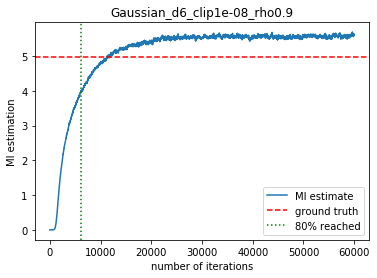

In [12]:
plt.plot(mi_copy, label='MI estimate')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
for t in range(len(mi_copy)):
    if (mi_copy[t]>.8*Ground_truth):
        plt.axvline(t,label='80% reached',linestyle=':',color='green')
        break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.title('{}_d{}_clip{}_rho{}'.format(density, opt.d, opt.gamma, opt.rho))
plt.legend()


Save the mutual information estimates.

In [13]:
torch.save(mi_copy, './PCM{}.pth'.format(opt.sample_size))